# Vision Transformer wave function

In [16]:
import matplotlib.pyplot as plt

import netket as nk

import jax
import jax.numpy as jnp

print(jax.devices())

import flax
from flax import linen as nn

from einops import rearrange

seed = 0
key = jax.random.key(seed)

[CpuDevice(id=0)]


## 1. Embedding

We begin by writing a flax module that, given a batch of $M$ spin configurations, first splits each configuration of shape $L\times L$ into $L^2/b^2$ patches of size $b\times b$. Then, each patch is embedded in $\mathbb{R}^d$, with $d$ the *embedding dimension*.


In [17]:
def extract_patches2d(x, patch_size):
    batch = x.shape[0]
    n_patches = int((x.shape[1] // patch_size**2) ** 0.5)
    x = x.reshape(batch, n_patches, patch_size, n_patches, patch_size)
    x = x.transpose(0, 1, 3, 2, 4)
    x = x.reshape(batch, n_patches, n_patches, -1)
    x = x.reshape(batch, n_patches * n_patches, -1)
    return x


class Embed(nn.Module):
    d_model: int  # dimensionality of the embedding space
    patch_size: int  # linear patch size
    param_dtype = jnp.float64

    def setup(self):
        self.embed = nn.Dense(
            self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )

    def __call__(self, x):
        x = extract_patches2d(x, self.patch_size)
        x = self.embed(x)

        return x

In [18]:
# test embedding module implementation
d_model = 16  # embedding dimension
patch_size = 2  # linear patch size

# initialize a batch of spin configurations, considering a system on a 10x10 square lattice
M = 10
L = 4

key, subkey = jax.random.split(key)
spin_configs = jax.random.randint(subkey, shape=(M, L * L), minval=0, maxval=1) * 2 - 1

print(f"{spin_configs.shape = }")

# initialize the embedding module
embed_module = Embed(d_model, patch_size)

key, subkey = jax.random.split(key)
params_embed = embed_module.init(subkey, spin_configs)

# apply the embedding module to the spin configurations
embedded_configs = embed_module.apply(params_embed, spin_configs)

print(f"{embedded_configs.shape = }")

spin_configs.shape = (10, 16)
embedded_configs.shape = (10, 4, 16)


Working with configurations of shape $10\times 10$ and choosing a patch size of $2\times 2$, the embedding module maps each configuration into a sequence of vectors $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, with $\mathbf{x}_i \in \mathbb{R}^d$ for all $i$. In the considered setup, the resulting number of vectors is $n=25$ and we have chosen an embedding dimension of $d=32$.

:::{warning}
The function that extracts the patches from the spin configuration must be adapted to the specific lattice geometry. In particular, the function `extract_patches2d` is designed for square lattice without basis.
:::

## 2. Transformer Encoder


### Multi-Head Attention

The core element of the Transformer architecture is the so-called *attention layer*, which processes the sequence of input vectors $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, with $\mathbf{x}_i \in \mathbb{R}^d$ for all $i$, producing a new sequence $(\boldsymbol{A}_1, \dots, \boldsymbol{A}_n)$, with $\boldsymbol{A}_i \in \mathbb{R}^d$. The goal of this transformation is to construct context-aware output vectors by combining all input vectors (see Ref. [VA17]):

\begin{equation}
    \boldsymbol{A}_i = \sum_{j=1}^n \alpha_{ij}(\boldsymbol{x}_i, \boldsymbol{x}_j) V \boldsymbol{x}_j \ .
\end{equation}

The attention weights $\alpha_{ij}(\boldsymbol{x}_i, \boldsymbol{x}_j)$ form a $n\times n$ matrix, where $n$ is the number of patches, which measure the relative importance of the $j$-$th$ input when computing the new representation of the $i$-$th$ input. To parametrize the ViT wave function, we consider a simplified attention mechanism, called *factored attention* (see Ref. [RM24, SV22]), taking the attention weights only depending on positions $i$ and $j$, but not on the actual values of the spins in these patches. In equations, factored attention leads to $\alpha_{ij}(\boldsymbol{x}_i, \boldsymbol{x}_j)=\alpha_{ij}$. Below, we show how to implement the factored attention module in flax.

In [19]:
class FactoredAttention(nn.Module):
    n_patches: int  # lenght of the input sequence
    d_model: int  # dimensionality of the embedding space (d in the equations)

    def setup(self):
        self.alpha = self.param(
            "alpha", nn.initializers.xavier_uniform(), (self.n_patches, self.n_patches)
        )
        self.V = self.param(
            "V", nn.initializers.xavier_uniform(), (self.d_model, self.d_model)
        )

    def __call__(self, x):
        y = jnp.einsum("i j, a b, M j b-> M i a", self.alpha, self.V, x)
        return y

For the specific application of approximating ground states of
quantum many-body spin Hamiltonians, factored attention yields equivalent performance with respect to the standard attention mechanism,
while reducing the computational cost and parameter usage (see Ref.[RA25]).

To improve the expressivity of the self-attention mechanism, Multi-Head attention can be considered, where for each position $i$ different attention representations $\boldsymbol{A}_i^{\mu}$ are computed, where $\mu = 1, \dots, h$ with $h$ the total number of heads. The different vectors $\boldsymbol{A}_i^{\mu} \in \mathbf{R}^{d/h}$ are computed in
parallel, concatenated together, and linearly combined through a matrix of weights $W$.

Below we build a flax module that implements the Factored Multi-Head Attention mechanism. In addition, we also provide a translational invariant implementation.

:::{note}
For approximating ground states of translationally invariant Hamiltonians, it is useful to implement translationally invariant attention mechanisms where $\alpha_{ij} = \alpha_{i-j}$.
:::

In [20]:
from functools import partial


@partial(jax.vmap, in_axes=(None, 0, None), out_axes=1)
@partial(jax.vmap, in_axes=(None, None, 0), out_axes=1)
def roll2d(spins, i, j):
    side = int(spins.shape[-1] ** 0.5)
    spins = spins.reshape(spins.shape[0], side, side)
    spins = jnp.roll(jnp.roll(spins, i, axis=-2), j, axis=-1)
    return spins.reshape(spins.shape[0], -1)


class FMHA(nn.Module):
    d_model: int  # dimensionality of the embedding space
    n_heads: int  # number of heads
    n_patches: int  # lenght of the input sequence
    transl_invariant: bool = False
    param_dtype = jnp.float64

    def setup(self):
        self.v = nn.Dense(
            self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )
        self.W = nn.Dense(
            self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )
        if self.transl_invariant:
            self.alpha = self.param(
                "alpha",
                nn.initializers.xavier_uniform(),
                (self.n_heads, self.n_patches),
                self.param_dtype,
            )
            sq_n_patches = int(self.n_patches**0.5)
            assert sq_n_patches * sq_n_patches == self.n_patches
            self.alpha = roll2d(
                self.alpha, jnp.arange(sq_n_patches), jnp.arange(sq_n_patches)
            )
            self.alpha = self.alpha.reshape(self.n_heads, -1, self.n_patches)
        else:
            self.alpha = self.param(
                "alpha",
                nn.initializers.xavier_uniform(),
                (self.n_heads, self.n_patches, self.n_patches),
                self.param_dtype,
            )

    def __call__(self, x):
        # apply the value matrix in paralell for each head
        v = self.v(x)

        # split the representations of the different heads
        v = rearrange(
            v,
            "batch n_patches (n_heads d_eff) -> batch n_patches n_heads d_eff",
            n_heads=self.n_heads,
        )

        # factored attention mechanism
        v = rearrange(
            v, "batch n_patches n_heads d_eff -> batch n_heads n_patches d_eff"
        )
        x = jnp.matmul(self.alpha, v)
        x = rearrange(
            x, "batch n_heads n_patches d_eff  -> batch n_patches n_heads d_eff"
        )

        # concatenate the different heads
        x = rearrange(
            x, "batch n_patches n_heads d_eff ->  batch n_patches (n_heads d_eff)"
        )

        # the representations of the different heads are combined together
        x = self.W(x)

        return x

In [21]:
# test Factored MultiHead Attention module
n_heads = 4  # number of heads
n_patches = embedded_configs.shape[1]  # lenght of the input sequence

# initialize the Factored Multi-Head Attention module
fmha_module = FMHA(d_model, n_heads, n_patches)

key, subkey = jax.random.split(key)
params_fmha = fmha_module.init(subkey, embedded_configs)

# apply the Factored Multi-Head Attention module to the embedding vectors
attention_vectors = fmha_module.apply(params_fmha, embedded_configs)

print(f"{attention_vectors.shape = }")

attention_vectors.shape = (10, 4, 16)


### Encoder Block

In each encoder block, the MultiHead attention mechanism is followed by a two-layers feed-forward neural network. Layer normalization and skip connections are also added to stabilize the training of deep architectures.

In [22]:
class EncoderBlock(nn.Module):
    d_model: int  # dimensionality of the embedding space
    n_heads: int  # number of heads
    n_patches: int  # lenght of the input sequence
    transl_invariant: bool = False
    param_dtype = jnp.float64

    def setup(self):
        self.attn = FMHA(
            d_model=self.d_model,
            n_heads=self.n_heads,
            n_patches=self.n_patches,
            transl_invariant=self.transl_invariant,
        )

        self.layer_norm_1 = nn.LayerNorm(param_dtype=self.param_dtype)
        self.layer_norm_2 = nn.LayerNorm(param_dtype=self.param_dtype)

        self.ff = nn.Sequential(
            [
                nn.Dense(
                    4 * self.d_model,
                    kernel_init=nn.initializers.xavier_uniform(),
                    param_dtype=self.param_dtype,
                ),
                nn.gelu,
                nn.Dense(
                    self.d_model,
                    kernel_init=nn.initializers.xavier_uniform(),
                    param_dtype=self.param_dtype,
                ),
            ]
        )

    def __call__(self, x):
        x = x + self.attn(self.layer_norm_1(x))

        x = x + self.ff(self.layer_norm_2(x))
        return x

Based on this block, we can implement a module for the full Transformer Encoder applying a sequence of encoder blocks. The number of these blocks is defined by the number of layers of the Transformer architecture.

In [23]:
class Encoder(nn.Module):
    num_layers: int  # number of layers
    d_model: int  # dimensionality of the embedding space
    n_heads: int  # number of heads
    n_patches: int  # lenght of the input sequence
    transl_invariant: bool = False

    def setup(self):
        self.layers = [
            EncoderBlock(
                d_model=self.d_model,
                n_heads=self.n_heads,
                n_patches=self.n_patches,
                transl_invariant=self.transl_invariant,
            )
            for _ in range(self.num_layers)
        ]

    def __call__(self, x):

        for l in self.layers:
            x = l(x)

        return x

In [24]:
# test Transformer Encoder module
num_layers = 2  # number of layers

# initialize the Factored Multi-Head Attention module
encoder_module = Encoder(num_layers, d_model, n_heads, n_patches)

key, subkey = jax.random.split(key)
params_encoder = encoder_module.init(subkey, embedded_configs)

# apply the Factored Multi-Head Attention module to the embedding vectors
x = embedded_configs
y = encoder_module.apply(params_encoder, x)

print(f"{y.shape = }")

y.shape = (10, 4, 16)


The Transformer Encoder processes the embedded patches $(\mathbf{x}_1, \cdots, \mathbf{x}_n)$, with $\mathbf{x}_i \in \mathbb{R}^d$, producing another sequence of vectors $(\mathbf{y}_1, \cdots, \mathbf{y}_n)$, with $\mathbf{y}_i \in \mathbb{R}^d$.

## 3. Output layer
For each configuration $\boldsymbol{\sigma}$, we compute its hidden representation $\boldsymbol{z}=\sum_{i=1}^n \mathbf{y}_i$. Then, we produce a single complex number representing its amplitude using the fully-connected layer defined in Ref. [CS17]:

\begin{equation}
    \text{Log}[\Psi(\boldsymbol{\sigma})] = \sum_{\alpha=1}^d \log\cosh \left( b_{\alpha} + \boldsymbol{w}_{\alpha} \cdot \boldsymbol{z} \right) \ ,
\end{equation}

:::{note}
The parameters $\{ b_\alpha, \boldsymbol{w}_\alpha \}$ are taken to be complex valued, contrary to the parameters of the Transformer Encoder which are all real valued.
:::

In [25]:
log_cosh = (
    nk.nn.activation.log_cosh
)  # Logarithm of the hyperbolic cosine, implemented in a more stable way


class OuputHead(nn.Module):
    d_model: int  # dimensionality of the embedding space
    param_dtype = jnp.float64

    def setup(self):
        self.out_layer_norm = nn.LayerNorm(param_dtype=self.param_dtype)

        self.norm2 = nn.LayerNorm(
            use_scale=True, use_bias=True, param_dtype=self.param_dtype
        )
        self.norm3 = nn.LayerNorm(
            use_scale=True, use_bias=True, param_dtype=self.param_dtype
        )

        self.output_layer0 = nn.Dense(
            self.d_model,
            param_dtype=self.param_dtype,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=jax.nn.initializers.zeros,
        )
        self.output_layer1 = nn.Dense(
            self.d_model,
            param_dtype=self.param_dtype,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=jax.nn.initializers.zeros,
        )

    def __call__(self, x):

        z = self.out_layer_norm(x.sum(axis=1))

        out_real = self.norm2(self.output_layer0(z))
        out_imag = self.norm3(self.output_layer1(z))

        out = out_real + 1j * out_imag

        return jnp.sum(log_cosh(out), axis=-1)

Combining the Embedding, Encoder and OutputHead modules we can implement a module for the full ViT architecture.

In [26]:
class ViT(nn.Module):
    num_layers: int  # number of layers
    d_model: int  # dimensionality of the embedding space
    n_heads: int  # number of heads
    patch_size: int  # linear patch size
    transl_invariant: bool = False

    @nn.compact
    def __call__(self, spins):
        x = jnp.atleast_2d(spins)

        Ns = x.shape[-1]  # number of sites
        n_patches = Ns // self.patch_size**2  # lenght of the input sequence

        x = Embed(d_model=self.d_model, patch_size=self.patch_size)(x)

        y = Encoder(
            num_layers=self.num_layers,
            d_model=self.d_model,
            n_heads=self.n_heads,
            n_patches=n_patches,
            transl_invariant=self.transl_invariant,
        )(x)

        log_psi = OuputHead(d_model=self.d_model)(y)

        return log_psi

# Symmetries

In [27]:

from netket.jax import logsumexp_cplx

class ViT_sym(nn.Module):
    num_layers: int  # number of layers
    d_model: int  # dimensionality of the embedding space
    n_heads: int  # number of heads
    patch_size: int  # linear patch size
    transl_invariant: bool = False
    parity: bool = False   # parity symmetry operation

    @nn.compact
    def __call__(self, spins):

        vit = ViT(  self.num_layers,
                    self.d_model,
                    self.n_heads,
                    self.patch_size,
                    transl_invariant=self.transl_invariant,)
        
        if self.parity:
            z_plus = vit(spins)
            z_minus =  vit((-1.)*spins)   
            return logsumexp_cplx(jnp.array([z_plus, z_minus]), axis=0)

    

# Test

In [28]:
# test ViT module

# initialize the ViT module
vit_module = ViT(num_layers, d_model, n_heads, patch_size)

key, subkey = jax.random.split(key)
params = vit_module.init(subkey, spin_configs)

# apply the ViT module
log_psi = vit_module.apply(params, spin_configs)

print(f"{log_psi.shape = }")


# test ViT_Sym module
vit_sym = ViT_sym(num_layers, d_model, n_heads, patch_size, parity=True)

key, subkey = jax.random.split(key)
params = vit_sym.init(subkey, spin_configs)

# apply the ViT module
log_psi = vit_sym.apply(params, spin_configs)

print(f"{log_psi.shape = }")

log_psi.shape = (10,)
log_psi.shape = (10,)


## Ground state optimization

We show how to train the ViT wave function on the two-dimensional $J_1$- $J_2$ Heisenberg model on a $10\times 10$ square lattice.
The system is described by the following Hamiltonian (with periodic boundary conditions):

$$
    \hat{H} = J_1 \sum_{\langle {\boldsymbol{r}},{\boldsymbol{r'}} \rangle} \hat{\boldsymbol{S}}_{\boldsymbol{r}}\cdot\hat{\boldsymbol{S}}_{\boldsymbol{r'}}
    + J_2 \sum_{\langle \langle {\boldsymbol{r}},{\boldsymbol{r'}} \rangle \rangle} \hat{\boldsymbol{S}}_{\boldsymbol{r}}\cdot\hat{\boldsymbol{S}}_{\boldsymbol{r'}} \ .
$$

We fix $J_2/J_1=0.5$ and we use the VMC_SRt driver (see Ref.[RAS24]) implemented in NetKet to optimize the ViT wave function.

In [ ]:
from netket.operator.spin import sigmax, sigmaz, sigmay

save = False
seed = 0
key = jax.random.key(seed)

n_dim = 2
J2 = 0.1

lattice = nk.graph.Hypercube(length=L, n_dim=n_dim, pbc=True, max_neighbor_order=2)

# Hilbert space of spins on the graph
hilbert = nk.hilbert.Spin(s=1 / 2, N=lattice.n_nodes, total_sz=0)

# Heisenberg J1-J2 spin hamiltonian

hamiltonian = nk.operator.Heisenberg(
    hilbert=hilbert, graph=lattice, J=[1.0, J2], sign_rule=[False, False]
).to_jax_operator()  # No Marshall sign rule

"""
#Ising Hamiltonian
hamiltonian = nk.operator.LocalOperator(hilbert)
for u, v in lattice.edges():
    hamiltonian += sigmaz(hilbert, u) * sigmaz(hilbert, v) 
"""

# Intiialize the ViT variational wave function
vit_module = ViT_sym(
    num_layers=2, d_model=32, n_heads=4, patch_size=2, transl_invariant=True, parity=True
)

key, subkey = jax.random.split(key)
params = vit_module.init(subkey, spin_configs)

# Metropolis Local Sampling
N_samples = 512
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert,
    graph=lattice,
    d_max=2,
    n_chains=N_samples,
    sweep_size=lattice.n_nodes,
)

optimizer = nk.optimizer.Sgd(learning_rate=0.0075)

key, subkey = jax.random.split(key, 2)
vstate = nk.vqs.MCState(
    sampler=sampler,
    model=vit_module,
    sampler_seed=subkey,
    n_samples=N_samples,
    n_discard_per_chain=0,
    variables=params,
    chunk_size=512,
)

N_params = nk.jax.tree_size(vstate.parameters)
print("Number of parameters = ", N_params, flush=True)

# Variational monte carlo driver
from netket.experimental.driver import VMC_SR

vmc = VMC_SR(
    hamiltonian=hamiltonian,
    optimizer=optimizer,
    diag_shift=1e-4,
    variational_state=vstate,
    mode="complex",
) 

Number of parameters =  23680
Automatic SR implementation choice:  NTK


In [ ]:
# Optimization
log = nk.logging.RuntimeLog()

N_opt = 200
vmc.run(n_iter=N_opt, out=log)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:07<?, ?it/s]


KeyboardInterrupt: 

We can visualize the training dynamics by plotting the mean energy as a function of the optimization steps:

Last value:  -0.17209053423543091


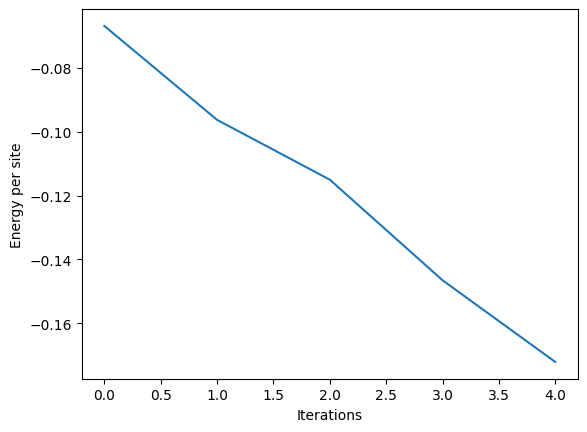

In [ ]:
energy_per_site = log.data["Energy"]["Mean"].real / (L * L * 4)

E_vs = energy_per_site[-1]
print("Last value: ", energy_per_site[-1])

plt.plot(energy_per_site)

plt.xlabel("Iterations")
plt.ylabel("Energy per site")

import os
if(save):
    os.makedirs('plot_ViT_J2/layers1_d16_heads2_patch2_sample1024_iter200/J=0,8_L=4', exist_ok=True)
    plt.savefig('plot_ViT_J2/layers1_d16_heads2_patch2_sample1024_iter200/J=0,8_L=4/Energy.png')
plt.show()

Correlation function

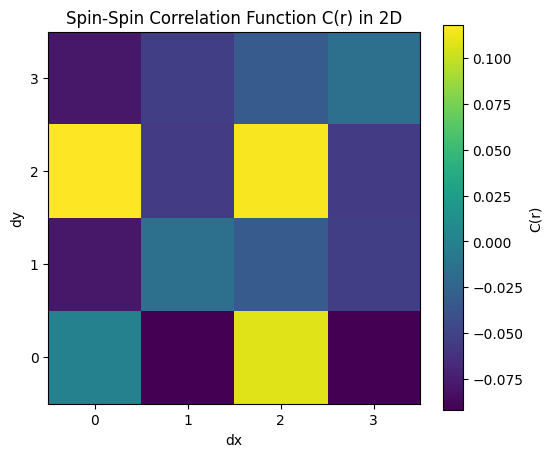

In [ ]:
import numpy as np

vstate.n_samples = 1024
N_tot = lattice.n_nodes


corr_r = np.zeros((L, L))
counts = np.zeros((L, L))

for i in range(N_tot):
    for j in range(N_tot):
        
        r = lattice.positions[i] - lattice.positions[j]

        corr_ij = 0.25 * (sigmaz(hilbert, i) * sigmaz(hilbert, j) + sigmax(hilbert, i) * sigmax(hilbert, j) + sigmay(hilbert, i) * sigmay(hilbert, j))

        exp = vstate.expect(corr_ij)

        #PBC
        r0, r1 = int(r[0]) % L , int(r[1]) % L

        corr_r[r0, r1] += exp.mean.real
        counts[r0, r1] += 1

corr_r /= counts 
corr_r[0, 0] = 0  # set C(0) = 0


plt.figure(figsize=(6,5))
plt.imshow(corr_r, origin='lower', cmap='viridis')
plt.colorbar(label='C(r)')
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('Spin-Spin Correlation Function C(r) in 2D')
plt.xticks(np.arange(L))  # integer ticks for x-axis
plt.yticks(np.arange(L)) 

if(save):
    plt.savefig('plot_ViT_J2/layers1_d16_heads2_patch2_sample1024_iter200/J=0,8_L=4/Corr.png')
plt.show()



Struct Factor

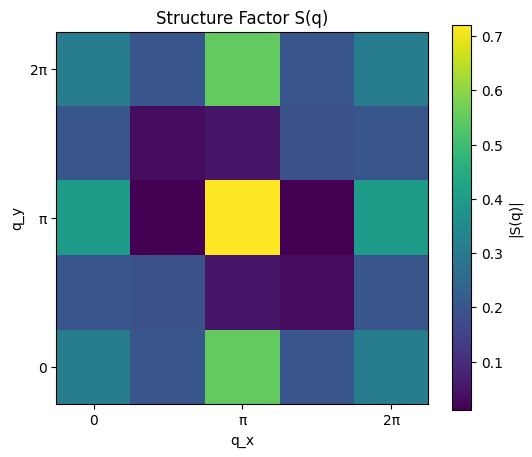

In [ ]:
# Compute the 2D Fourier transform of corr_r
S_q = np.fft.fft2(corr_r)

# Account for periodicity
S_q_periodic = np.zeros((L+1, L+1), dtype=S_q.dtype)
S_q_periodic[:L, :L] = S_q  
S_q_periodic[L, :] = S_q_periodic[0, :]    
S_q_periodic[:, L] = S_q_periodic[:, 0]    

#plot
plt.figure(figsize=(6,5))
plt.imshow(np.abs(S_q_periodic), origin='lower', cmap='viridis')
plt.colorbar(label='|S(q)|')
plt.xlabel('q_x')
plt.ylabel('q_y')
plt.title('Structure Factor S(q)')

# Set integer ticks for axes
plt.xticks([0, 1/2*L, L], ['0', 'π', '2π'])
plt.yticks([0, 1/2*L, L], ['0', 'π', '2π'])

if(save):
    plt.savefig('plot_ViT_J2/layers1_d16_heads2_patch2_sample1024_iter200/J=0,8_L=4/Struct.png')
plt.show()


Sanity Check: Exact Diagonalization

In [ ]:
E_gs, ket_gs = nk.exact.lanczos_ed(hamiltonian, compute_eigenvectors=True)

print(f"Exact ground state energy = {E_gs[0]:.3f}")
E_exact = E_gs[0]/(L*L*4)
print(f"Exact ground state energy per site= {E_exact}")

Exact ground state energy = -35.273
Exact ground state energy per site= -0.5511477727006608


Relative error between energy of the variational gs and the energy of the exact one

In [ ]:
e = np.abs((E_vs - E_exact)/E_exact)
print(f"Relative error = {e}")

Relative error = 0.6877597211503264


Fidelity

In [ ]:
import netket.experimental.observable as obs
import netket.operator as op

# I can compute infidelity like this only if I have 2 variational states
""" 

infidelity_op = obs.InfidelityOperator(target_state= vstate)
infidelity = vstate.expect(infidelity_op).mean.real
print(f"Infidelity = {infidelity}")

"""
#Compute fidelity between variational state and exact ground state in case of symmetrical degenaracy
# Create a state superposition of ground state and the all spins flipped ground state, 
# so it become symmetrical in the 2 degenerate gs, and I can apply the fidelity reliably
"""
vstate_array = vstate.to_array()

if J2==0: # degenerate ground state
    
    X_tensor = op.spin.sigmax(hilbert, 0)
    for i in range(1, lattice.n_nodes):
        X_tensor = X_tensor @ op.spin.sigmax(hilbert, i)

    ket_gs_flip = X_tensor @ ket_gs
    vstate_flip = X_tensor @ vstate_array

    vstate_sym = (vstate_array + vstate_flip) / (np.linalg.norm(vstate_array + vstate_flip))
    ket_gs_sym = (ket_gs + ket_gs_flip ) /  (np.linalg.norm(ket_gs + ket_gs_flip))

else:
    vstate_sym = vstate_array / np.linalg.norm(vstate_array)
    ket_gs_sym = ket_gs / np.linalg.norm(ket_gs)


overlap_val = vstate_sym.conj() @ ket_gs_sym
fidelity_val = np.abs(overlap_val) ** 2 / (np.vdot(vstate_sym, vstate_sym) * np.vdot(ket_gs_sym, ket_gs_sym))

print(f"Fidelity = {fidelity_val[0].real}")

"""

# Check the spin parity symmetry of the variational state
# Apply the spin parity operator to the variational state and check if it remain invariant,
# Checking that the fidelity is 1

vstate_array = vstate.to_array()

X_tensor = op.spin.sigmax(hilbert, 0)
for i in range(1, lattice.n_nodes):
    X_tensor = X_tensor @ op.spin.sigmax(hilbert, i)

vstate_flip = X_tensor @ vstate_array
vstate_sym = (vstate_array + vstate_flip) / (np.linalg.norm(vstate_array + vstate_flip))

overlap_val = vstate_sym.conj() @ vstate_array
fidelity_val = np.abs(overlap_val) ** 2 / (np.vdot(vstate_sym, vstate_sym) * np.vdot(vstate_array, vstate_array))

print(f"Fidelity = {fidelity_val}")



Fidelity = (1+0j)


Magnetization

In [ ]:
#construct the observable total magnetization
tot_magn = sum([sigmaz(hilbert, i) for i in lattice.nodes()])

tot_magn_vstate = vstate.expect(tot_magn).mean.real
print(f"Magnetization = {tot_magn_vstate}" )

Magnetization = 0.0


Variance

In [ ]:
from netket.experimental import observable as obs

"""
variance_obs = obs.VarianceObservable(hamiltonian, use_Oloc_squared=True)
variance_vstate = vstate.expect(variance_obs)
print(f"Variance = {variance_vstate}")
"""

variance = log.data["Energy"]["Variance"][-1].real
print(f"Variance = {variance}")




Variance = 1063.9788828840751


V-score

In [ ]:
v_score = L*L*variance/(E_vs*L*L*4)
print(f"V-score = {v_score}")

V-score = -1733.7646293528226
